In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

In [2]:
first_pageviews = pd.read_csv("data/init/first_pageviews.csv")
users = pd.read_csv("data/init/users.csv")
subscriptions = pd.read_csv("data/init/subscriptions.csv")

In [3]:
first_pageviews.head()

,date_id,anonymous_id,exp_id
0,2020-01-16,4d005f94-e06f-493c-b569-9efb5ce4d203,NaN
1,2020-01-16,948ad58a-f483-4007-aa56-280aa018427b,NaN
2,2020-01-16,31f4f2e4-4ae6-417b-8a6d-53b98a719145,NaN
3,2020-01-16,24747dc7-355a-44b0-95c6-0caa91cd4ae4,NaN
4,2020-01-16,0162c4f8-7bc2-4432-90b9-bfb61f5e57b3,NaN


In [4]:
first_pageviews.dtypes

date_id          object
anonymous_id     object
exp_id          float64
dtype: object

In [5]:
first_pageviews["date_id"] = pd.to_datetime(first_pageviews["date_id"])

In [6]:
users.head()

,anonymous_id,user_id
0,e575dd8c-f02c-4a1a-8a53-fef7ff2b9f95,b67781da-3a0f-48af-80d8-728d3ec31c66
1,a92532b2-0317-49bb-9f00-3d9b9ae71ea5,ce1764ca-91a2-4c2e-95fe-c415c5df7be5
2,9c39b4d4-d7da-49e2-bcd9-4abee3e211f6,b24712a4-40b7-4841-a9e9-f566d9ed48a9
3,858cc4cc-dcd2-4897-815b-500a2ee8c00e,d0e4f27e-11ab-470c-85db-4f7389ba63d4
4,96a9ad69-568e-40bd-9ff7-3e6b8e0d3f9a,91b679ad-38cc-4569-b5fc-8a98dc858b8d


In [7]:
users.dtypes

anonymous_id    object
user_id         object
dtype: object

In [8]:
subscriptions.head()

,user_id,created_at,client_app
0,b67781da-3a0f-48af-80d8-728d3ec31c66,2020-01-26 09:00:55.628471160,android
1,ce1764ca-91a2-4c2e-95fe-c415c5df7be5,2020-01-30 10:43:16.359589080,ios
2,b24712a4-40b7-4841-a9e9-f566d9ed48a9,2020-02-15 21:19:35.663792880,web
3,d0e4f27e-11ab-470c-85db-4f7389ba63d4,2020-02-13 04:45:52.198410780,ios
4,91b679ad-38cc-4569-b5fc-8a98dc858b8d,2020-02-10 13:24:29.670026400,android


In [9]:
subscriptions.dtypes

user_id       object
created_at    object
client_app    object
dtype: object

In [10]:
subscriptions["created_at"] = pd.to_datetime(subscriptions["created_at"])

In [11]:
first_pageviews["date_id"].min()

Timestamp('2020-01-16 00:00:00')

In [12]:
first_pageviews["date_id"].max()

Timestamp('2020-02-29 00:00:00')

In [13]:
# validate assignment
first_pageviews["exp_id"].fillna(0).value_counts(normalize=True)

0.0      0.931430
101.0    0.034329
102.0    0.034242
Name: exp_id, dtype: float64

In [14]:
subscriptions["created_at"].describe()

count                             20053
unique                            20053
top       2020-03-24 09:29:39.583493700
freq                                  1
first     2020-01-16 00:04:51.422682360
last         2021-07-22 12:35:35.551566
Name: created_at, dtype: object

In [15]:
subscribers = (first_pageviews
               .merge(users,
                      how="inner",
                      on="anonymous_id")
               .merge(subscriptions,
                      how="inner",
                      on="user_id"))

In [16]:
(subscribers["created_at"] - subscribers["date_id"]).describe()

count                       20053
mean      10 days 10:29:25.203095
std       16 days 18:22:21.773311
min        0 days 00:01:34.961045
25%        2 days 02:38:44.314964
50%        5 days 09:57:38.923988
75%       12 days 05:00:17.385367
max      538 days 12:35:35.551566
dtype: object

# Create datasets

In [17]:
# filter
exp_pageviews = first_pageviews.loc[first_pageviews["exp_id"].isin([101, 102])]

In [18]:
daily_pageviews = (exp_pageviews
                   .groupby(["date_id", "exp_id"])
                   .agg({"anonymous_id": "count"})
                   .rename(columns={"anonymous_id": "unique_visitors"})
                   .reset_index())

In [19]:
daily_pageviews["exp_id"] = daily_pageviews["exp_id"].astype(int)

/Users/at/miniconda3/envs/ironhack/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


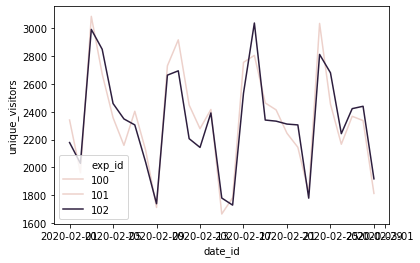

In [20]:
sns.lineplot(data=daily_pageviews,
             x="date_id",
             y="unique_visitors",
             hue="exp_id");

In [21]:
daily_pageviews.groupby("exp_id").agg({"unique_visitors": "sum"})

,unique_visitors
exp_id,
101,67887
102,67715


In [22]:
# merge datasets
exp_data_all = (exp_pageviews
                .merge(users,
                   how="left",
                   on="anonymous_id")
                .merge(subscriptions,
                   how="left",
                   on="user_id"))

In [23]:
users_to_delete = subscriptions[subscriptions["created_at"] > "2020-04-01"]

In [24]:
subscriptions = subscriptions.drop(users_to_delete.index).reset_index(drop=True)

In [25]:
subscriptions_new = (subscriptions
                     .loc[subscriptions["created_at"] < "2020-03-01"]
                     .reset_index(drop=True))
subscriptions_add = (subscriptions
                     .loc[subscriptions["created_at"]
                          .between("2020-03-01", "2020-04-01", inclusive=True)]
                     .reset_index(drop=True))

In [26]:
subscriptions_new.merge(subscriptions_add, how="inner", on="user_id")

,user_id,created_at_x,client_app_x,created_at_y,client_app_y


In [27]:
subscriptions_new["created_at"].max()

Timestamp('2020-02-29 23:58:41.641215300')

In [28]:
subscriptions_new.to_csv("../data/2020-03-01/subscriptions_mar01.csv", index=False)
subscriptions_add.to_csv("../data/2020-04-01/subscriptions_apr01.csv", index=False)

In [29]:
len(subscriptions_new)

16158

In [30]:
len(subscriptions_add)

3360

In [37]:
users = (users
         [~users["user_id"].isin(users
                                 .merge(users_to_delete, on="user_id", how="inner")
                                 ["user_id"])]
         .reset_index(drop=True))

In [38]:
users_new = users[~users["user_id"].isin(subscriptions_add["user_id"])].reset_index(drop=True)
users_add = users[users["user_id"].isin(subscriptions_add["user_id"])].reset_index(drop=True)

In [39]:
users_new.merge(users_add, how="inner", on="user_id")

,anonymous_id_x,user_id,anonymous_id_y


In [40]:
users_new.to_csv("../data/2020-03-01/users_mar01.csv", index=False)
users_add.to_csv("../data/2020-04-01/users_apr01.csv", index=False)

In [43]:
users_ext = pd.concat([users_new, users_add])

In [44]:
subscriptions_ext = pd.concat([subscriptions_add, subscriptions_new])

In [ ]:
# merge datasets
exp_data = (exp_pageviews
            .merge(users_new,
                   how="left",
                   on="anonymous_id")
            .merge(subscriptions_new,
                   how="left",
                   on="user_id"))

In [ ]:
extra_users = subscribers.loc[subscribers["user_id"].isin(exp_data.loc[(~exp_data["user_id"].isna()) & (exp_data["created_at"].isna())]["user_id"]), "user_id"]

In [ ]:
users_new = users_new[~users["user_id"].isin(extra_users)].reset_index(drop=True)

In [ ]:
users_new

In [ ]:
users_new.merge(users_add, how="inner", on="user_id")

In [ ]:
users_new.to_csv("../data/users_mar01.csv", index=False)

In [ ]:
exp_data.info()

In [ ]:
exp_data["subscribed"].value_counts()

In [ ]:
exp_data = exp_data.assign(subscribed=np.where(exp_data["created_at"].isna(), 0, 1))

In [ ]:
exp_data.head()

In [ ]:
subscribed_count = (exp_data
                    .groupby(["exp_id", "subscribed"])
                    .agg({"anonymous_id": "count"}))
subscribed_total = (exp_data
                    .groupby("exp_id")
                    .agg({"anonymous_id": "count"}))
subscribed_count.div(subscribed_total, level="exp_id")*100

In [ ]:
exp_data_ext = (exp_pageviews
                .merge(users_ext,
                       how="left",
                       on="anonymous_id")
                .merge(subscriptions_ext,
                       how="left",
                       on="user_id"))

In [ ]:
exp_data_ext = exp_data_ext.assign(subscribed=np.where(exp_data_ext["user_id"].isna(), 0, 1))
subscribed_count_ext = (exp_data_ext
                        .groupby(["exp_id", "subscribed"])
                        .agg({"anonymous_id": "count"}))
subscribed_total_ext = (exp_data_ext
                        .groupby("exp_id")
                        .agg({"anonymous_id": "count"}))
subscribed_count_ext.div(subscribed_total_ext, level="exp_id")*100

In [ ]:
exp_data

In [ ]:
import scipy

In [ ]:
exp_a = exp_data.loc[exp_data["exp_id"] == 101, "subscribed"]
exp_b = exp_data.loc[exp_data["exp_id"] == 102, "subscribed"]
scipy.stats.ttest_ind(exp_a, exp_b, equal_var=False)

In [ ]:
exp_a_ext = exp_data_ext.loc[exp_data_ext["exp_id"] == 101, "subscribed"]
exp_b_ext = exp_data_ext.loc[exp_data_ext["exp_id"] == 102, "subscribed"]
scipy.stats.ttest_ind(exp_a_ext, exp_b_ext, equal_var=False)

In [ ]:
exp_data_all = exp_data_all.assign(subscribed=np.where(exp_data_all["user_id"].isna(), 0, 1))

In [ ]:
exp_a_all = exp_data_all.loc[exp_data_all["exp_id"] == 101, "subscribed"]
exp_b_all = exp_data_all.loc[exp_data_all["exp_id"] == 102, "subscribed"]
scipy.stats.ttest_ind(exp_a_all, exp_b_all, equal_var=False)